In [1]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/Downloads/ptsa_plot-master/')
sys.path.append('/home1/john/johnModules')
from brain_labels import MTL_labels, LTC_labels, PFC_labels, OTHER_labels, ALL_labels # all location labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *

df = get_data_index("r1") # all RAM subjects

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/timeseries.py:526: FutureWarning: xarray subclass TimeSeriesX should explicitly define __slots__
  class TimeSeriesX(TimeSeries):


In [2]:
HPC_labels = [MTL_labels[i] for i in [0,1,2,3,4,8,9,10,11,12,20,24,25]]
HPC_labels

['left ca1',
 'left ca2',
 'left ca3',
 'left dg',
 'left sub',
 'right ca1',
 'right ca2',
 'right ca3',
 'right dg',
 'right sub',
 'ca1',
 'left hippocampus',
 'right hippocampus']

In [82]:
# for now, get an example subject's FR data
sub = 'R1112M' #'R1163T' #'R1112M' # subjects with FR1 and catFR1. SRs of 1000 and 500 tho
# sess = 2
exp = 'FR1'
sub_df = df[(df.subject == sub)  & (df.experiment == exp)] # & (df.session == sess)]
sub_df

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
639,NaN,protocols/r1/subjects/R1112M/experiments/FR1/s...,protocols/r1/subjects/R1112M/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1112M/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1112M/localizations/0/m...,NaN,0,R1112M,R1112M,1.0,protocols/r1/subjects/R1112M/experiments/FR1/s...
640,NaN,protocols/r1/subjects/R1112M/experiments/FR1/s...,protocols/r1/subjects/R1112M/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1112M/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1112M/localizations/0/m...,NaN,1,R1112M,R1112M,1.0,protocols/r1/subjects/R1112M/experiments/FR1/s...
641,NaN,protocols/r1/subjects/R1112M/experiments/FR1/s...,protocols/r1/subjects/R1112M/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1112M/experiments/FR1/s...,0,NaN,2,protocols/r1/subjects/R1112M/localizations/0/m...,NaN,2,R1112M,R1112M,1.0,protocols/r1/subjects/R1112M/experiments/FR1/s...


## Get raw, 80-120 Hz, and 250-500 Hz eeg and detect ripples!

In [83]:
import mne
from ptsa.data.filters import ButterworthFilter
%matplotlib inline
from pylab import *
%autoreload

start = -5000
end = 2000

ripple_array = []; trial_nums = []; ripple_mstime_array = []
HPC_ct = 0; session_ct = 0
for row in sub_df.itertuples():    
    sub = row.subject; session = row.session; exp = row.experiment
    mont = int(row.montage); loc = int(row.localization)
    reader = CMLReadDFRow(row)
    evs = reader.load('task_events')
    evs_free_recall = evs[evs.type=='REC_WORD']
    # remove events with Inter-Recall Intervals too small. Use start time since that's what will show in PSTH
    evs_free_recall = evs_free_recall[np.append(True,np.diff(evs_free_recall.mstime)>5000)] #abs(start))]
    pairs = reader.load('pairs')
    tal_struct, bipolar_pairs, mpchans = get_bp_tal_struct(sub, montage=mont, localization=loc)
    elec_regions,_ = get_elec_regions(tal_struct) 
    
    eeg = reader.load_eeg(events=evs_free_recall, rel_start=start, rel_stop=end, clean=True, scheme=pairs)
    # events X electrodes X time
    eeg_ptsa = eeg.to_ptsa()
    sr = int(eeg.samplerate)
    eeg_rip_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[80.,120.], filt_type='bandpass',order=2).filter()
    if sr == 1000: # 500 is half the sr so go to 499
        eeg_ied_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[250.,499.], filt_type='bandpass',order=2).filter()
    elif sr == 500:
        eeg_ied_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=249., filt_type='highpass',order=2).filter()
    
    eeg_rip_band = ptsa_to_mne(eeg_rip_band,[0,end-start])
    _ = eeg_rip_band.apply_hilbert(envelope=True)
    eeg_ied_band = ptsa_to_mne(eeg_ied_band,[0,end-start])
    _ = eeg_ied_band.apply_hilbert(envelope=True)
    eeg_raw = ptsa_to_mne(eeg_ptsa,[0,end-start])    
    
    HPC_names = []
    for channel in range(len(elec_regions)):
        if elec_regions[channel] in HPC_labels:
            if session_ct == 0:
                HPC_ct+=1      
            HPC_names.append(elec_regions[channel])
            eeg_rip = eeg_rip_band.get_data()[:,channel,:] # get data from MNE container
            eeg_ied = eeg_ied_band.get_data()[:,channel,:]
            eeg_mne = eeg_raw.get_data()[:,channel,:]
            ripplelogic, iedlogic = detectRipples(eeg_rip,eeg_ied,eeg_mne,sr) #,np.array(evs_free_recall.mstime))
            ripple_array = superVstack(ripple_array,ripplelogic) # append across electrodes
            trial_nums = np.append(trial_nums,ripplelogic.shape[0])
    session_ct = session_ct + 1        

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1112M/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1112M/tal/R1112M_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1112M/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1112M/eeg.noreref/R1112M_FR1_0_01Dec15_1545.params.txt
/data/eeg/R1112M/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePath

22 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
22 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
22 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1112M/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1112M/tal/R1112M_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1112M/experiments/FR1/sessions/1/ephys/current_processed/sources.json
/data/eeg/R1112M/eeg.noreref/R1112M_FR1_1_03Dec15_0938.params.txt
/data/eeg/R1112M/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePath

28 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
28 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
28 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1112M/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1112M/tal/R1112M_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1112M/experiments/FR1/sessions/2/ephys/current_processed/sources.json
/data/eeg/R1112M/eeg.noreref/R1112M_FR1_2_05Dec15_0921.params.txt
/data/eeg/R1112M/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePath

10 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
10 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
10 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


Largest cluster p-value is: 0.09900990099009901


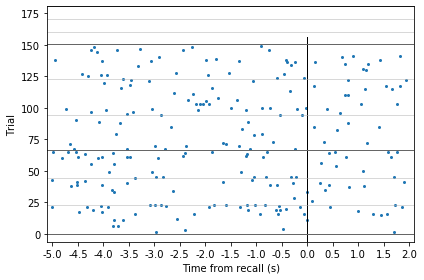

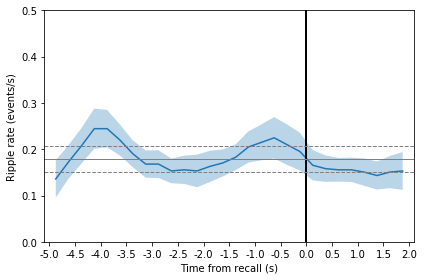

In [97]:
# for the raster and PSTH binarize the data by using the start indices of the ripple
%autoreload
sr_factor = (1000/sr)
start_array = np.zeros((ripple_array.shape))
end_array = np.zeros((ripple_array.shape))
num_trials = ripple_array.shape[0]
for trial in range(num_trials):
    ripplelogictrial = ripple_array[trial]
    starts,ends = getLogicalChunks(ripplelogictrial)
    temp_row = np.zeros(len(ripplelogictrial))
    temp_row[starts] = 1
    start_array[trial] = temp_row
    temp_row = np.zeros(len(ripplelogictrial))
    temp_row[ends] = 1
    end_array[trial] = temp_row

## NEVERMIND. Do it based on ISI of recall times, NOT ripple times. That's actually what Norman et al did
# # now that we have a start_array with all ripples, need to check ISIs to make sure
# # we're not double-dipping on recall events. For example, if two recall events
# # are only 500 ms apart, we don't want to put the same ripple in the PSTH twice just 500 ms apart
# # remove duplicate ripples < this interripple interval (IRI) time.
# IRI_thresh = abs(start) # Setting to start (PSTH beginning time) makes sense for PSTH
# ripple_idxs = np.where(ripple_mstime_array)
# ripple_abs_times = ripple_mstime_array[ripple_idxs]
# IRIs = np.diff(ripple_abs_times) # inter-ripple intervals
# 
# # this looks at current IRI and cumulative IRIs and eliminates everything but first one
# for rip in range(len(IRIs)): # for each ripple, check if next ripples are within IRI_thresh
#     if IRIs[rip]<=IRI_thresh:
#         # find how many into future are <=IRI_thresh
#         next_rip = 1
#         while np.sum(IRIs[rip:rip+next_rip])<=IRI_thresh:            
#             next_rip+=1
#             if (rip+next_rip)>=len(IRIs):
#                 break
#         # now you know how many ripples to remove
#         IRIs[rip:rip+next_rip-1] = Inf # so it won't be caught again in next step of for loop
#          # +1 below because used diff so always removing ripples after 1st
#         start_array[ripple_idxs[0][rip+1:rip+1+next_rip],ripple_idxs[1][rip+1:rip+1+next_rip]] = 0
#         # note: end_array can be left alone, since it's only indexed after finding a ripple from start_array

# plot raster
subplots(1,1,figsize=(6,4))    
scatter(np.where(start_array)[1]*sr_factor+start,np.where(start_array)[0],s=4) # SWR time v. trial
xticks(np.arange(start,end+1,500),np.arange(start/1000,end/1000+1,0.5))
xlabel('Time from recall (s)')
ylabel('Trial')
ax = plt.gca()
ax.set_xlim(start-100,end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]], linewidth=1,linestyle='-',color=(0,0,0))
for s in range(1,len(trial_nums)):
    if np.mod(s,HPC_ct)==0:
        plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))
    else:
        plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.5,linestyle='-',color=(.7,.7,.7))
plot([ax.get_xlim()[0],ax.get_xlim()[1]],-.5*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))        
plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums))*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))
ax.autoscale(enable=True, axis='y', tight=True)
tight_layout()

# make a PSTH based on start times of SWRs
binsize = 250 # ms
smoothing_triangle = 5 # triangular smoothing window width
samples = 100
PSTH,bin_centers = fullPSTH(start_array,binsize,smoothing_triangle,sr,start)
boot_samples = bootstrap(start_array, bootnum=samples, samples=None, # bootstrap error bars using resampling
               bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,start))
boot_SD = np.std(boot_samples,0)

# create a resampling surrogate to probe chance and do cluster stats
nbins = int(np.ceil(start_array.shape[1]/binsize))
shuffledRate = np.zeros((nbins,samples))
realRate = PSTH
samples = 100
num_trials = start_array.shape[0]
time_length = start_array.shape[1]
shuffledRate = []
for i in range(samples):
    # get list of trials with replacement and the number of ripples within them
    rip_ct = np.sum(start_array,1)
    permdata = np.zeros(np.shape(start_array))
    for trial in range(num_trials):
        if rip_ct[trial]>0:
            rand_times = randint(0,time_length,int(rip_ct[trial]))
            permdata[trial,rand_times] = 1
    permPSTH,_ = fullPSTH(permdata,binsize,smoothing_triangle,sr,start)        
    shuffledRate = superVstack(shuffledRate,permPSTH)
pad = smoothing_triangle-3 # factor is how many points from middle does triangle go?
shuffledRate = shuffledRate[:,pad:-pad] # remove padded sides
mean_shuffled_rate = np.mean(shuffledRate)
shuffled_std = np.std(shuffledRate)

# find significant clusters
cluster_thresh = 1.96
thresh = [mean_shuffled_rate-(cluster_thresh*shuffled_std),mean_shuffled_rate+(cluster_thresh*shuffled_std)]
temp = (shuffledRate<thresh[0]) | (shuffledRate>thresh[1])
max_clusts = []
for i in range(samples):
    starts,ends = getLogicalChunks(temp[i,:])
    if len(starts)>0:
        clust = (np.array(ends)-np.array(starts))+1
        max_clusts.append(np.max(clust))
    else: max_clusts.append(0)
# actual data
temp = (realRate<thresh[0]) | (realRate>thresh[1])
starts,ends = getLogicalChunks(temp)
real_clust = (np.array(ends)-np.array(starts))+1

sig_mask = np.zeros(len(temp)) # get locations of significant clusters
clusterPval = []
for k in range(len(clust)):
    clusterPval.append( (np.sum(max_clusts>clust[k])+1) / (samples+1))
    if clusterPval[k]<0.05:
        sig_mask[starts[k]:ends[k]+1]=1
max_cluster_actual_data = np.max(real_clust)
# convert significant clsuters to bins
clust_start,clust_end = getLogicalChunks(sig_mask)
sig_clust_ranges = []
for cl in range(len(clust_start)):
    sig_bins = bin_centers[clust_start[c]:clust_end[c]+1] # get sig. bins and create xvalues for a line
    sig_clust_ranges.append([np.min(sig_bins)-binsize/2,np.max(sig_bins)+binsize/2])

# plot PSTH
subplots(1,1,figsize=(6,4))
xr = bin_centers #np.arange(start,end,binsize)
#plot(xr,norm_count[0]) # actual data
plot(xr,PSTH)
fill_between(xr, PSTH+boot_SD, PSTH-boot_SD, alpha = 0.3)
# bootstrap SE using random sample with replacement

xticks(np.arange(start,end+1,500),np.arange(start/1000,end/1000+1,500/1000))
xlabel('Time from recall (s)')
ylabel('Ripple rate (events/s)')
ax = plt.gca()
ax.set_ylim(0,0.5)
ax.set_xlim(start-100,end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=2,linestyle='-',color=(0,0,0));
x_width = [ax.get_xlim()[0],ax.get_xlim()[1]]
plot(x_width,list(mean_shuffled_rate*np.ones(2)),linewidth=1,color=(0.5,0.5,0.5));
plot(x_width,list((mean_shuffled_rate+shuffled_std)*np.ones(2)),linewidth=1,linestyle='--',color=(0.5,0.5,0.5));
plot(x_width,list((mean_shuffled_rate-shuffled_std)*np.ones(2)),linewidth=1,linestyle='--',color=(0.5,0.5,0.5));
if len(sig_clust_ranges)>0:
    for cl in range(len(sig_clust_ranges)):
        plot(sig_clust_ranges[cl],[0.45,0.45],color=(1,0.7,0.23),linewidth=3)
        print('Cluster p-value: '+str(clusterPval[cl]))
else: print('Largest cluster p-value is: '+str(clusterPval[0]))
tight_layout()
a=1;

In [91]:
evs_free_recall.shape

(22, 26)

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


IndexError: index 22 is out of bounds for axis 0 with size 22

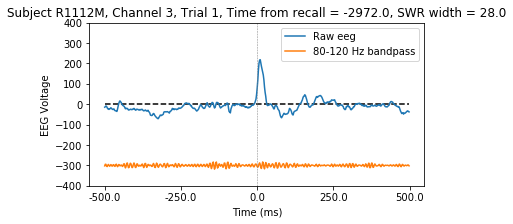

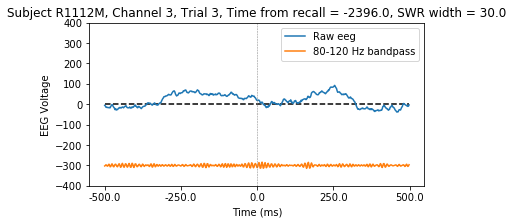

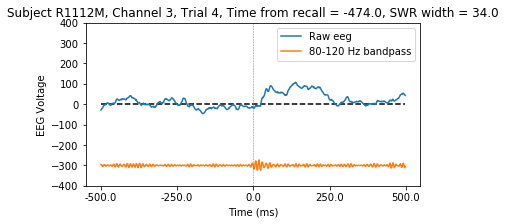

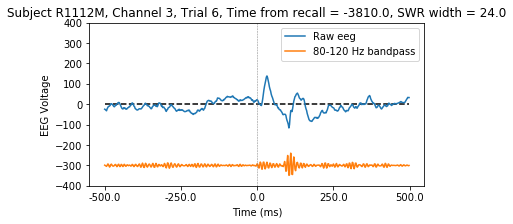

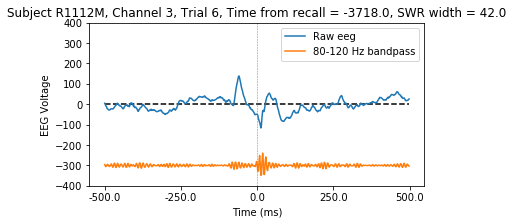

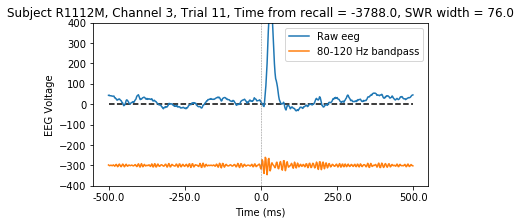

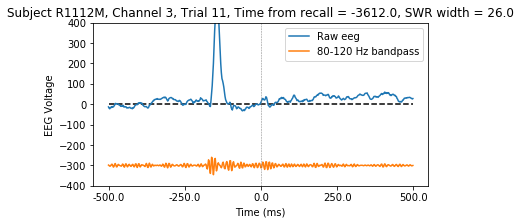

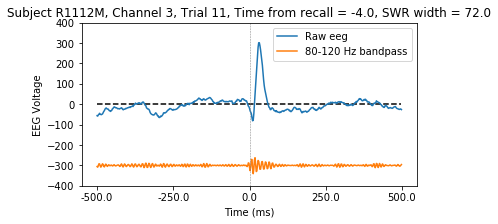

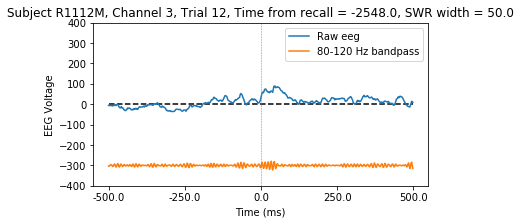

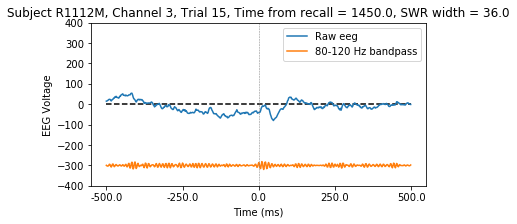

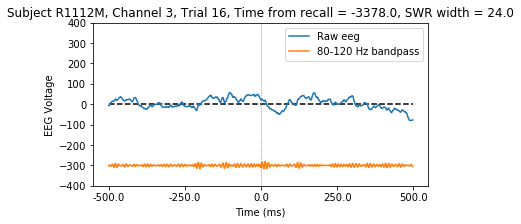

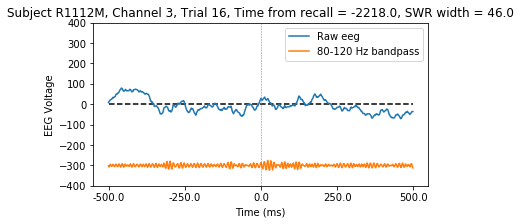

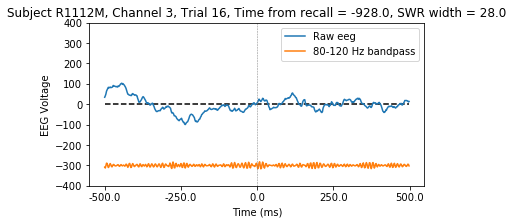

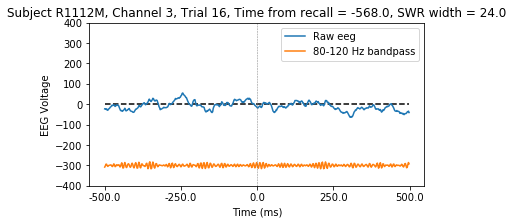

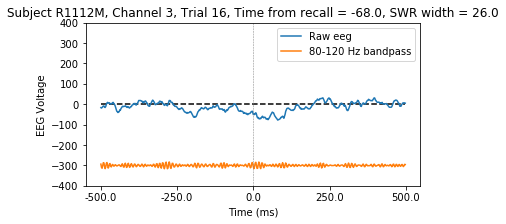

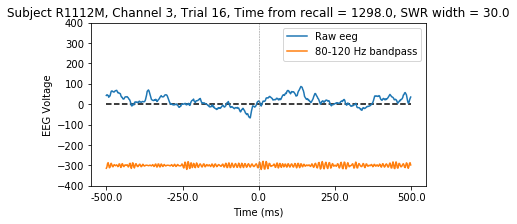

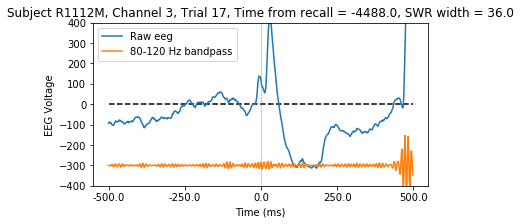

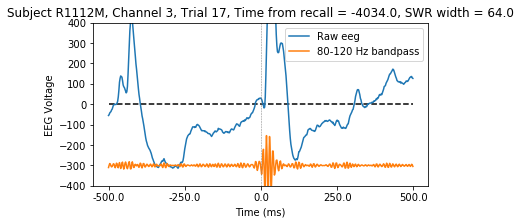

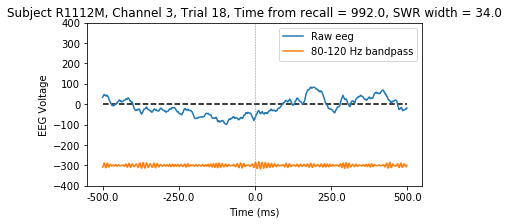

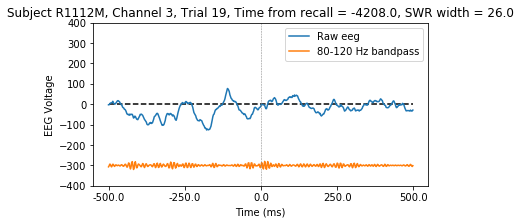

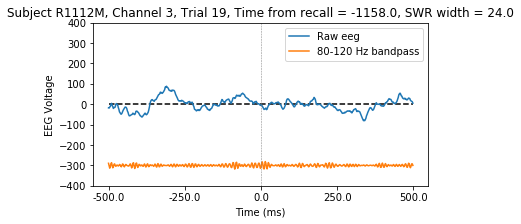

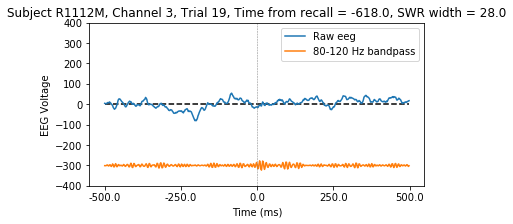

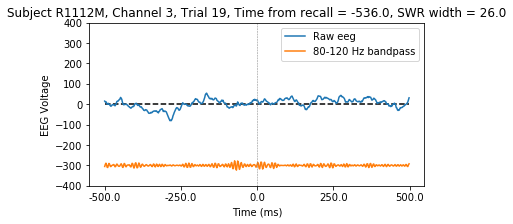

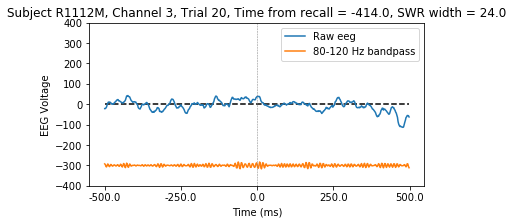

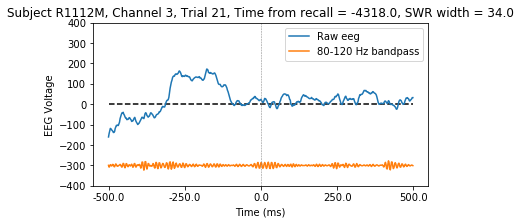

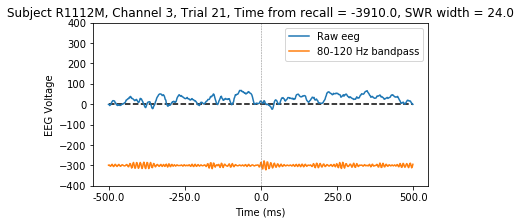

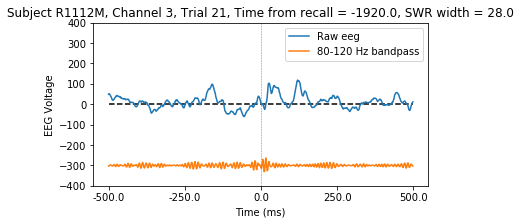

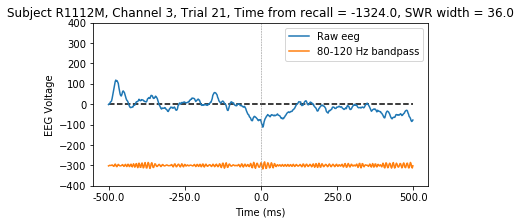

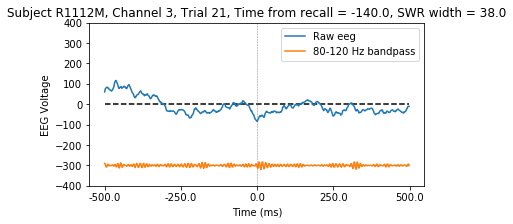

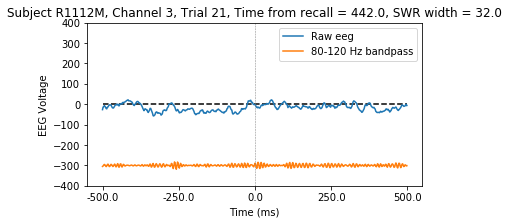

In [96]:
# let's look at some of these SWR events! 

# Need to run top eeg load first to get start_array and sr.
# start_array is recall_events X time with binary 1 for start of each detected SWR

%autoreload
from ptsa.data.filters import ButterworthFilter

session = 0 
temp_sub_df = sub_df[(sub_df.subject==sub) & (sub_df.session == session)] 
temp_sub_df

pre_rip = -500
post_rip = 500

first_trial = 0
trials_to_print = 40 # note: will skip trials with no ripples
ymin = -400 #np.min(stim_eeg[trial,:])
ymax = 400 #np.max(stim_eeg[trial,:])
display_mult = 5 # increase 80-120 Hz by this factor to see it better on graph
y_offset = -300 # move 80-120 filtered band down for visualization purposes

xr = np.arange(0,(post_rip-pre_rip)/sr_factor)
yr = np.arange(ymin,ymax)
num_ripples = np.sum(start_array)

trial_ct = 0
for row in temp_sub_df.itertuples():
    # get bipolar pairs
    sub = row.subject; mont = int(row.montage); loc = int(row.localization)
    exp = row.experiment; session = int(row.session)
    reader = CMLReadDFRow(row)
    evs = reader.load('task_events')
    evs_free_recall = evs[evs.type=='REC_WORD']
    # remove events with Inter-Recall Intervals too small. Use start time since that's what will show in PSTH
    evs_free_recall = evs_free_recall[np.append(True,np.diff(evs_free_recall.mstime)>5000)] #abs(start))]
    
    # should really rewrite this to use "pairs" from CMLReaders instead of tal_struct
    tal_struct, bipolar_pairs, mpchans = get_bp_tal_struct(sub, montage=mont, localization=loc)
    elec_regions,_ = get_elec_regions(tal_struct)      
    
    eeg = reader.load_eeg(events=evs_free_recall, rel_start=start, rel_stop=end, clean=True, scheme=pairs)
    eeg_ptsa = eeg.to_ptsa()
    eeg_ptsa = eeg_ptsa.baseline_corrected((start,end))
#     eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[58.,62.], filt_type='stop', order=4).filter()
#     eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[118.,122.], filt_type='stop', order=4).filter()
#     eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[178.,182.], filt_type='stop', order=4).filter()
    eeg_80120 = eeg_ptsa.filtered([80.,120.], filt_type='bandpass', order=4)
    
    for channel in range(len(elec_regions)):
        if elec_regions[channel] in HPC_labels:
            for trial in range(HPC_ct*eeg_ptsa.shape[0]): # maximum trials is # elecs * recall_events
                if trial_ct >= (first_trial) and trial_ct<(first_trial+trials_to_print):
                    if np.sum(start_array[trial_ct])>0: # if there is a ripple in this trial
                        rip_times = (np.array(np.where(start_array[trial_ct]))*sr_factor)[0] # convert to ms
                        rip_lengths = ((sr_factor*np.array(np.where(end_array[trial_ct])))-rip_times)[0]
                        for rip in range(len(rip_times)): # get each ripple   
                            rip_time = rip_times[rip]
                            rip_length = rip_lengths[rip]
                            #print(str(rip_time+start))
                            # note: any time dealing with eeg, need to account for sampling rate (see all the sr_factors)
                            if rip_time>abs(pre_rip) and rip_time<(eeg_ptsa.shape[2]*sr_factor-abs(post_rip)): # if enough time before/after ripple to plot
                                stim_eeg = eeg_ptsa[trial_ct,channel,int((rip_time+pre_rip)/sr_factor):int((rip_time+post_rip)/sr_factor)]
                                filt_eeg_rip = eeg_80120[trial_ct,channel,int((rip_time+pre_rip)/sr_factor):int((rip_time+post_rip)/sr_factor)]
                                
                                plt.figure(figsize=(6, 3)) 
                                ax = plt.subplot(111)
                                plt.plot(xr,stim_eeg)
                                plt.plot(xr,display_mult*filt_eeg_rip+y_offset)
                                plt.ylabel('EEG Voltage'); plt.xlabel('Time (ms)')
                                plt.plot(abs(pre_rip/sr_factor)*np.ones(len(yr)),yr,marker='',linewidth=0.5,linestyle='--',color=[0.5,0.5,0.5])
                                plt.legend(['Raw eeg','80-120 Hz bandpass'])
                                plt.title('Subject '+sub+', Channel '+str(channel)+', Trial '+str(trial_ct)+', Time from recall = '
                                          +str(rip_time+start)+', SWR width = '+str(rip_length))
                                plt.xticks(np.arange(0,post_rip-pre_rip+1,post_rip/4),np.arange(pre_rip,post_rip+1,post_rip/2))
                                ax.set_ylim([ymin,ymax])
                                plt.hlines(0,xr[0],xr[-1], linestyle='--', color='k')
                trial_ct+=1 # keep track of which trial we're on out of total ELEC X RECALL trials
a=1;

### rip_lengths[0]

In [89]:

start = -5000
end = 2000